In [1]:
def add_flipped_images(images, measurements):
    
    for idx in range(len(images)):
        image_flipped = np.fliplr(images[idx])
        measurement_flipped = -measurements[idx]
        images.append(image_flipped)
        measurements.append(measurement_flipped)


In [2]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from scipy.ndimage.interpolation import rotate, shift, zoom

base_dir = "./training_data/"

tracks_to_process = ["Track1_4", "Track1_5R"]#, "Track2"]

In [3]:
def Add_Shadow(image):
    
    r = randint(1,3)
    
    im_width = image.shape[1]
    im_height = image.shape[0]
    
    shadow_width = int(im_width * .4)
    shadow_height = int(im_height * .4)
    
    x=0
    y=0
    
    if r == 1: # left of image
        x = 0
        y = 0
        shadow_height = im_height
        
    elif r == 2: # right of image
        x = im_width - shadow_width
        y = 0
        shadow_height = im_height
        
    elif r == 3: # bottom of image
        x = 0
        y = im_height - shadow_height
        shadow_width = im_width
        
    elif r == 4: # top of image
        x = 0
        y = 0
        shadow_width = im_width
    
    overlay = image.copy()
    output = image.copy()
    
    cv2.rectangle(overlay, (x, y), (x+shadow_width, y+shadow_height), (20, 20, 20), -1)
    alpha = 0.7;

    # apply the overlay
    cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)
    
    return output

In [4]:
# change brightness of image by random amount
from random import randint

def Augment_Brightness(image):

    #image = cv2.imread('test.jpg') #load rgb image
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV) #convert it to hsv

    h, s, v = cv2.split(hsv)
    
    tweak_amount = randint(-75, 75)
    
    newV = np.clip(np.int32(v) + tweak_amount, 0, 255)
    
    v = np.uint8(newV)
    
    final_hsv = cv2.merge((h, s, v))

    image = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB)
    
    return image

In [5]:
def rand_jitter(temp):
    #if np.random.random() > .7:
    #    temp[np.random.randint(0,28,1), :] = 0
    #if np.random.random() > .7:
    #    temp[:, np.random.randint(0,28,1)] = 0
    #if np.random.random() > .5:
    temp = shift(temp, shift=(np.random.randint(-20,20,1), 0, 0))
    #if np.random.random() > .7:
    #    temp = rotate(temp, angle = np.random.randint(-20,20,1), reshape=False)
    return temp
    

In [6]:
def read_lines_from_csv(filename):
    lines = []
    
    csv_filename = base_dir + track_number + '/driving_log.csv'
    
    with open(csv_filename) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
            
    return lines    

In [7]:
def trim_repeated_lines(lines, max_repeat_count=5):
    
    repeated_count = 0
    
    last_measurement = 0.0
    
    trimmed_lines = []
    
    for idx in range(len(lines)):
        
        line = lines[idx]
        
        # take current measurement from line
        measurement = float(line[3])
        
        # add line on to the trimmed lines list
        trimmed_lines.append(line)
        
        
        # keep track of repeated count
        if (idx > 0) and (measurement==0.0) and (measurement == last_measurement):
            repeated_count+=1
        
        # if we have x repeats in a row, truncate them to x-1 then start afresh
        if repeated_count >= max_repeat_count:
            trimmed_lines = trimmed_lines[:-1 * (max_repeat_count-1)]
            
            repeated_count=0 # reset trimmed count
        
        # record last measurement for next loop round
        last_measurement = measurement
        
        
    return trimmed_lines

3327
1945


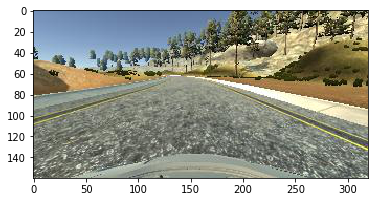

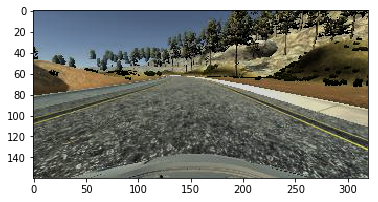

1530
1036


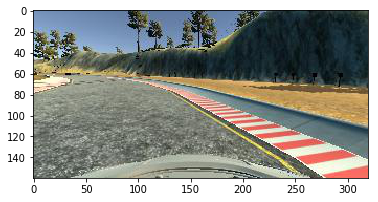

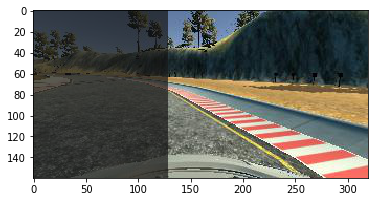

(29556, 160, 320, 3)


In [25]:
# load the images for processing


images = []
measurements = []
    
for track_number in tracks_to_process:
    
    csv_filename = base_dir + track_number + '/driving_log.csv'
    
    lines = read_lines_from_csv(csv_filename)
    
    print(len(lines))
    lines = trim_repeated_lines(lines, 3)
    print(len(lines))
    
    drawn = 0
    
    #Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(track_number + '_output.avi',fourcc, 10.0, (320,80))

    for line in lines:
        for idx in range(0, 3): # loop through the center, left and right images on each line of the file
            source_path = line[idx]
            filename = source_path.split('\\')[-1]
            current_path = base_dir + track_number + '/IMG/' + filename

            image = cv2.imread(current_path)

            if not image is None:

                #note drive.py reads image in RGB format, imread reads in RGB, 
                #so we will flip it here
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                if drawn == 0:
                    plt.imshow(image)
                    plt.show()
                    
                #image = cv2.GaussianBlur(image,(3,3),0)
                
                if np.random.random() > .9:
                    image = rand_jitter(image)
                
                if np.random.random() > .6:
                    image = Augment_Brightness(image)
                
                if np.random.random() > .8:
                    image = Add_Shadow(image)
                
                #image = cv2.Canny(image, 60, 60*3)
                
                #image = cv2.HoughLines()
                
                if drawn == 0:
                    imgplot = plt.imshow(image)
                    plt.show()
                    
                    drawn = 1

                yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                
                images.append(yuv)
                

                measurement = float(line[3])

                steering_adjustment = 0.2
                if idx==1:
                    measurement += steering_adjustment
                elif idx == 2:
                    measurement -= steering_adjustment

                measurements.append(measurement)
                
                if idx == 0:
                    clone = image.copy()  
                    clone = clone[60:140, :]
                    
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    cv2.putText(clone, 'Angle=' + str(measurement) , (60, 50), font, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
                                
                    out.write(cv2.cvtColor(clone, cv2.COLOR_RGB2BGR))
                
    out.release()

    # run through all images and generate a new image flipped in y, 
    # add flipped steering commands for those too! We are trying to remove bias 
    # for the mostly left turn track 1
    add_flipped_images(images, measurements)


images, measurements = shuffle(images, measurements)

X_train = np.array(images)
y_train = np.array(measurements)

print(X_train.shape)

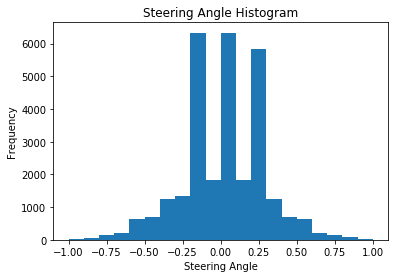

In [9]:
import matplotlib.pyplot as plt
#from numpy.random import normal
#gaussian_numbers = normal(size=1000)
plt.hist(measurements, bins=(-1.0, -.9,-.8,-.7,-.6,-.5, -.4, -.3, -.2,-.1, 0, .1, .2, .3, .4, .5, .6, .7,.8, .9,1.0))
plt.title("Steering Angle Histogram")
plt.xlabel("Steering Angle")
plt.ylabel("Frequency")
plt.show()

In [10]:
#my_generator = myGenerator()
#model.fit_generator(my_generator, samples_per_epoch = 60000, nb_epoch = 2, verbose=2, show_accuracy=True, callbacks=[], validation_data=None, class_weight=None, nb_worker=1)

In [11]:
def basic_model(model):

    model.add(Flatten())
    
    return model

In [12]:
def LeNet_model(model):
    
    my_init = TruncatedNormal(mean = 0, stddev = 1e-01)
    
    #kernel_initializer='truncated_normal', bias_initializer='zeros'
    
    model.add(Conv2D(6,(5,5),activation="relu", kernel_initializer=my_init, bias_initializer='zeros'))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(6,(5,5),activation="relu", kernel_initializer=my_init, bias_initializer='zeros'))
    model.add(MaxPooling2D())
    
    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(120, activation='relu', kernel_initializer=my_init, bias_initializer='zeros'))
    model.add(Dropout(0.5))
    model.add(Dense(84, activation='relu', kernel_initializer=my_init, bias_initializer='zeros'))
    
    return model

In [13]:
# tried to replicate the model at:
# https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/
# https://arxiv.org/pdf/1704.07911.pdf

def NVIDIA_PilotNet_model(model):
    
    dropout = .6
    
    my_init = TruncatedNormal(mean = 0, stddev = 1e-01)
    
    model.add(Conv2D(24,(5,5),strides=(2,2),activation="relu", kernel_initializer=my_init, bias_initializer='zeros'))
    #model.add(MaxPooling2D())
    
    model.add(Dropout(dropout))
    
    model.add(Conv2D(36,(5,5),strides=(2,2),activation="relu", kernel_initializer=my_init, bias_initializer='zeros'))
    #model.add(MaxPooling2D())
    
    model.add(Dropout(dropout))
    
    model.add(Conv2D(48,(5,5),strides=(2,2),activation="relu", kernel_initializer=my_init, bias_initializer='zeros'))
    #model.add(MaxPooling2D())
    
    model.add(Dropout(dropout))
    
    model.add(Conv2D(64,(3,3),strides=(1,1),activation="relu", kernel_initializer=my_init, bias_initializer='zeros'))
    #model.add(MaxPooling2D())
    
    model.add(Dropout(dropout))
    
    model.add(Conv2D(64,(3,3),strides=(1,1),activation="relu", kernel_initializer=my_init, bias_initializer='zeros'))
    #model.add(MaxPooling2D())
    
    model.add(Flatten())
    
    model.add(Dropout(dropout))
    model.add(Dense(100, activation='relu', kernel_initializer=my_init, bias_initializer='zeros'))
    model.add(Dropout(dropout))
    model.add(Dense(50, activation='relu', kernel_initializer=my_init, bias_initializer='zeros'))
    model.add(Dropout(dropout))
    model.add(Dense(10, activation='relu', kernel_initializer=my_init, bias_initializer='zeros'))
    
    return model

In [26]:
# tried to replicate the model at:
# https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/
# https://arxiv.org/pdf/1704.07911.pdf

def NVIDIA_PilotNet2_model(model):
    
    dropout_cnn = .2
    dropout = .5
    
    #my_init = TruncatedNormal(mean = 0, stddev = 1e-01)
    #'glorot_normal'
    
    model.add(Conv2D(24,(5,5),strides=(2,2),activation="elu", kernel_initializer='he_normal', bias_initializer='zeros'))
    #model.add(MaxPooling2D())
    model.add(BatchNormalization())
    #model.add(Dropout(dropout_cnn))
    
    model.add(Conv2D(36,(5,5),strides=(2,2),activation="elu", kernel_initializer='he_normal', bias_initializer='zeros'))
    #model.add(MaxPooling2D())
    model.add(BatchNormalization())
    #model.add(Dropout(dropout_cnn))
    
    model.add(Conv2D(48,(5,5),strides=(2,2),activation="elu", kernel_initializer='he_normal', bias_initializer='zeros'))
    #model.add(MaxPooling2D())
    model.add(BatchNormalization())
    #model.add(Dropout(dropout_cnn))
    
    model.add(Conv2D(64,(3,3),strides=(1,1),activation="elu", kernel_initializer='he_normal', bias_initializer='zeros'))
    #model.add(MaxPooling2D())
    model.add(BatchNormalization())
    #model.add(Dropout(dropout_cnn))
    
    model.add(Conv2D(64,(3,3),strides=(1,1),activation="elu", kernel_initializer='he_normal', bias_initializer='zeros'))
    #model.add(MaxPooling2D())
    model.add(BatchNormalization())
    
    model.add(Flatten())
    
    model.add(Dropout(dropout))
    model.add(Dense(100, activation='elu', kernel_initializer='he_normal', bias_initializer='zeros'))
    
    model.add(BatchNormalization())
    
    model.add(Dropout(dropout))
    model.add(Dense(50, activation='elu', kernel_initializer='he_normal', bias_initializer='zeros'))
    
    model.add(BatchNormalization())
    
    model.add(Dropout(dropout))
    model.add(Dense(10, activation='elu', kernel_initializer='he_normal', bias_initializer='zeros'))
    
    return model

In [27]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Conv2D, MaxPooling2D, Cropping2D, Dropout
from keras.initializers import TruncatedNormal
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization

batch_size = 256
epochs = 15
learning_rate = 0.0005

early_stop = 0

model = Sequential()

model.add(Cropping2D(cropping=((60,20), (0,0)), input_shape=(160,320,3)))

#model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160, 320, 3)))
model.add(Lambda(lambda x: x / 255.0))# - 0.5))

model_to_use = 3

if model_to_use == 1:
    print("using basic model")
    model = basic_model(model)
    
elif model_to_use == 2:
    print("using LeNet")
    model = LeNet_model(model)

elif model_to_use == 3:
    print("using NVIDIA PilotNet")
    model = NVIDIA_PilotNet2_model(model)

model.add(Dense(1))

# setup learning rate with Adam Optimizer
adam = Adam(lr=learning_rate)

# configure early stopping so we are not waiting longer than needed and also reduces overfitting

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model.compile(loss='mse', optimizer=adam)

if early_stop > 0:
    model.fit(X_train, y_train, validation_split=0.2, shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=[early_stopping])
else:
    model.fit(X_train, y_train, validation_split=0.2, shuffle=True, batch_size=batch_size, epochs=epochs)

model.save('model.h5')

print("Training complete!")


using NVIDIA PilotNet
Train on 23644 samples, validate on 5912 samples
Epoch 1/15
23644/23644 [==============================] - 113s - loss: 1.1484 - val_loss: 0.2804
Epoch 2/15
23644/23644 [==============================] - 111s - loss: 0.3707 - val_loss: 0.0640
Epoch 3/15
23644/23644 [==============================] - 111s - loss: 0.2131 - val_loss: 0.0533
Epoch 4/15
23644/23644 [==============================] - 111s - loss: 0.1478 - val_loss: 0.0478
Epoch 5/15
23644/23644 [==============================] - 111s - loss: 0.1113 - val_loss: 0.0470
Epoch 6/15
23644/23644 [==============================] - 111s - loss: 0.0867 - val_loss: 0.0460
Epoch 7/15
23644/23644 [==============================] - 111s - loss: 0.0739 - val_loss: 0.0431
Epoch 8/15
23644/23644 [==============================] - 111s - loss: 0.0641 - val_loss: 0.0409
Epoch 9/15
23644/23644 [==============================] - 122s - loss: 0.0598 - val_loss: 0.0397
Epoch 10/15
23644/23644 [==============================]

In [28]:
from PIL import Image
from io import BytesIO
import base64

imgPath = "./training_data/Track1_4/IMG/center_2017_10_17_22_46_46_373.jpg" #IMG/left_2017_10_17_23_51_48_056.jpg"#center_2017_10_17_23_51_05_522.jpg"

with open(imgPath, mode='rb') as file: # b is important -> binary
    test_image = file.read()
#test_image = cv2.imread(imgPath)
#test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

imgString = base64.b64encode(test_image)

pil_image = Image.open(BytesIO(base64.b64decode(imgString)))

opencvImage_yuv = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2YUV)
        
image_array = np.array(opencvImage_yuv)
        
steering_angle = float(model.predict(image_array[None, :, :, :], batch_size=1))

print(steering_angle)

-0.14001990854740143


(160, 320, 3)


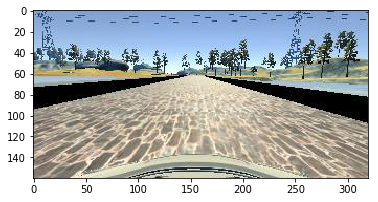

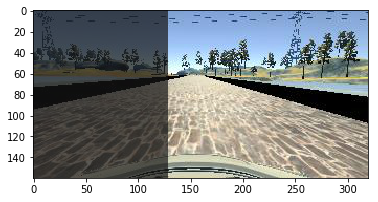

In [29]:
print(image_array.shape)
imgplot = plt.imshow(cv2.cvtColor(opencvImage_yuv, cv2.COLOR_YUV2RGB))
plt.show()

rgb = cv2.cvtColor(opencvImage_yuv, cv2.COLOR_YUV2RGB)

output = Add_Shadow(rgb)

imgplot = plt.imshow(output)
plt.show()